# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
sample_size = 10000
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 64
fuzzification_kernel_size = 16
enrich_lemmas_with_wn = False

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
X_train, y_train, X_test, y_test = X_train[:sample_size], y_train[:sample_size], X_test[:sample_size], y_test[:sample_size]
sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel()
model = DisCoFuzz(
    embedding_model,
    enrich_lemmas_with_wn=enrich_lemmas_with_wn
)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_train["sent_1"].to_list() + X_train["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.23790537,  0.05306077,  0.07269607, ...,  0.0751098 ,
         0.00704085, -0.01477477],
       [ 0.08852167, -0.09751743, -0.22334981, ...,  0.03462371,
         0.01768375,  0.04077251],
       [ 0.15320931,  0.2597466 , -0.2082253 , ..., -0.09995275,
        -0.05916547, -0.04577245],
       ...,
       [ 0.16191015,  0.12579906, -0.05918671, ..., -0.07039167,
        -0.10289254, -0.03268277],
       [ 0.27350608,  0.04741481, -0.05511398, ...,  0.12433725,
         0.15227653, -0.11344279],
       [ 0.12429293, -0.10776943,  0.10518764, ..., -0.04523624,
         0.10054126, -0.03883333]], dtype=float32)

In [5]:
X_train = model.fit(X_train)
X_train = model.predict_batch(X_train, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate model

In [6]:
eval_harness.fit(X_train)
sims_df = eval_harness.get_similarities(X_train)
sims_df.head()


	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for baseline_sent approac

,fuzzy_baseline_sent_cos_sim,fuzzy_baseline_tok_cos_sim,fuzzy_intersection+intersection_cos_sim,fuzzy_intersection+mean_cos_sim,fuzzy_intersection+union_cos_sim,fuzzy_mean_cos_sim,fuzzy_selective_intersection+intersection+mean_cos_sim,fuzzy_selective_intersection+mean_cos_sim,fuzzy_selective_intersection+union_cos_sim,fuzzy_baseline_sent_wasserstein-1_sim,...,fuzzy_baseline_tok_quantum_sim,fuzzy_intersection+intersection_quantum_sim,fuzzy_intersection+mean_quantum_sim,fuzzy_intersection+union_quantum_sim,fuzzy_mean_quantum_sim,fuzzy_selective_intersection+intersection+mean_quantum_sim,fuzzy_selective_intersection+mean_quantum_sim,fuzzy_selective_intersection+union_quantum_sim,baseline_sent_cos_sim,baseline_tok_cos_sim
0,0.080596,-0.077712,0.007416,0.002897,0.007416,-0.023593,0.003947,0.003947,0.003310,-0.139925,...,-0.075276,-0.004329,-0.003507,-0.004329,-0.135382,0.001554,0.001554,0.000100,-0.143688,-0.124497
1,-0.005800,-0.008840,0.024273,0.000927,0.024273,0.007871,0.003365,0.003365,0.001720,-0.138908,...,0.023325,-0.014350,-0.000774,-0.014350,0.036609,0.004116,0.004116,0.000911,-0.146585,0.040091
2,-0.166447,-0.194001,0.005225,-0.000559,0.005225,-0.069142,0.003959,0.003959,0.003369,-0.038416,...,-0.231020,-0.003529,-0.002252,-0.003529,-0.358861,0.000473,0.000473,-0.000286,-0.101913,-0.285893
3,-0.049836,-0.021375,0.000347,0.000440,0.000347,-0.021677,-0.083281,-0.083281,-0.077047,-0.046928,...,-0.028691,0.000492,0.000233,0.000492,-0.034579,-0.038128,-0.038128,-0.008137,-0.135199,-0.025038
4,0.232676,0.063763,0.001397,0.001145,0.001397,0.142097,-0.150246,-0.150246,-0.156177,0.235077,...,0.019736,-0.002076,-0.001844,-0.002076,0.222110,-0.032097,-0.032097,-0.007801,0.376279,0.134164


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

# Visualizations

## Custom similarities vs cosine similarity in original space

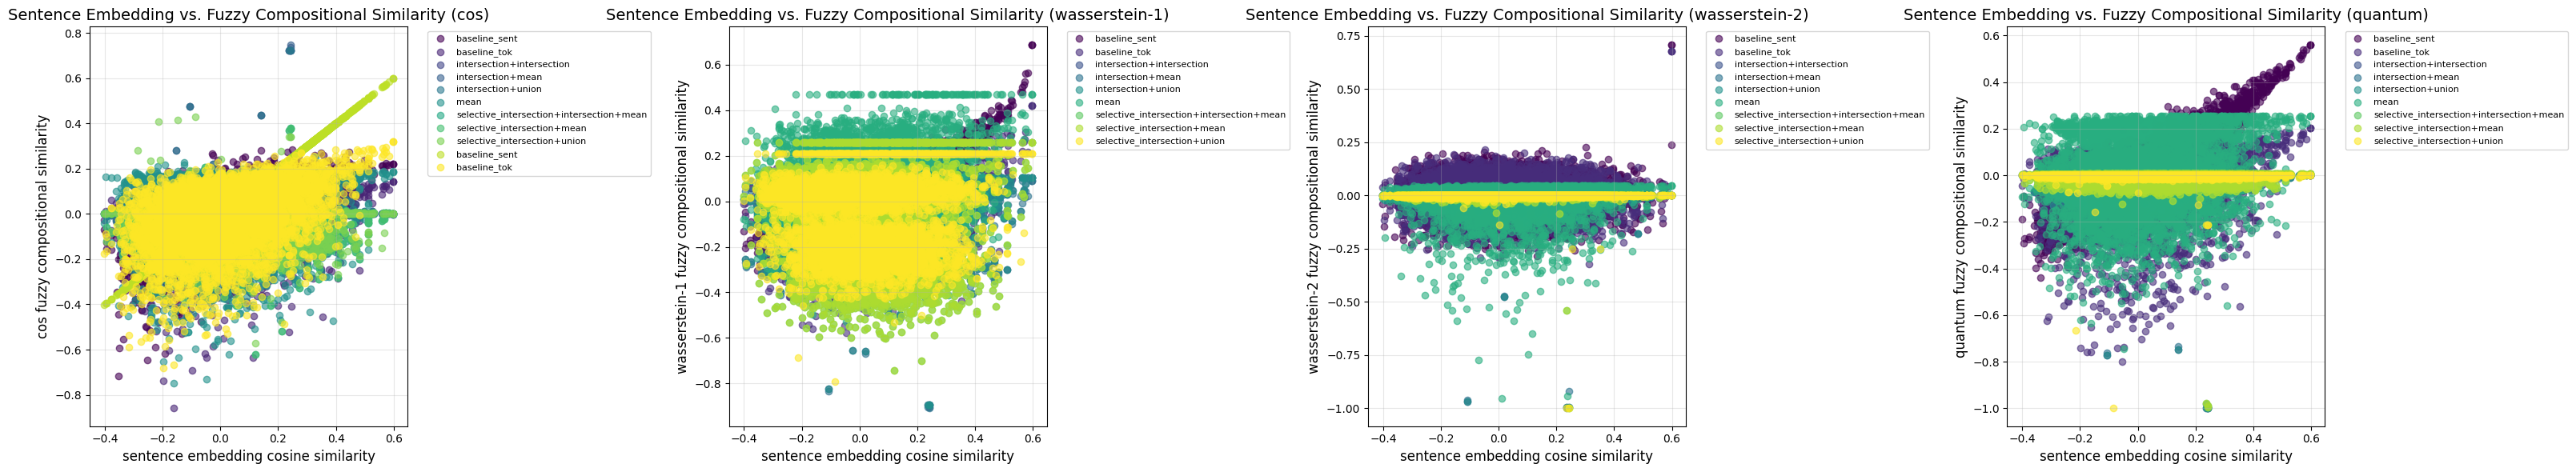

In [8]:
eval_harness.visualize_similarities(sims_df)

## Confusion Matrices

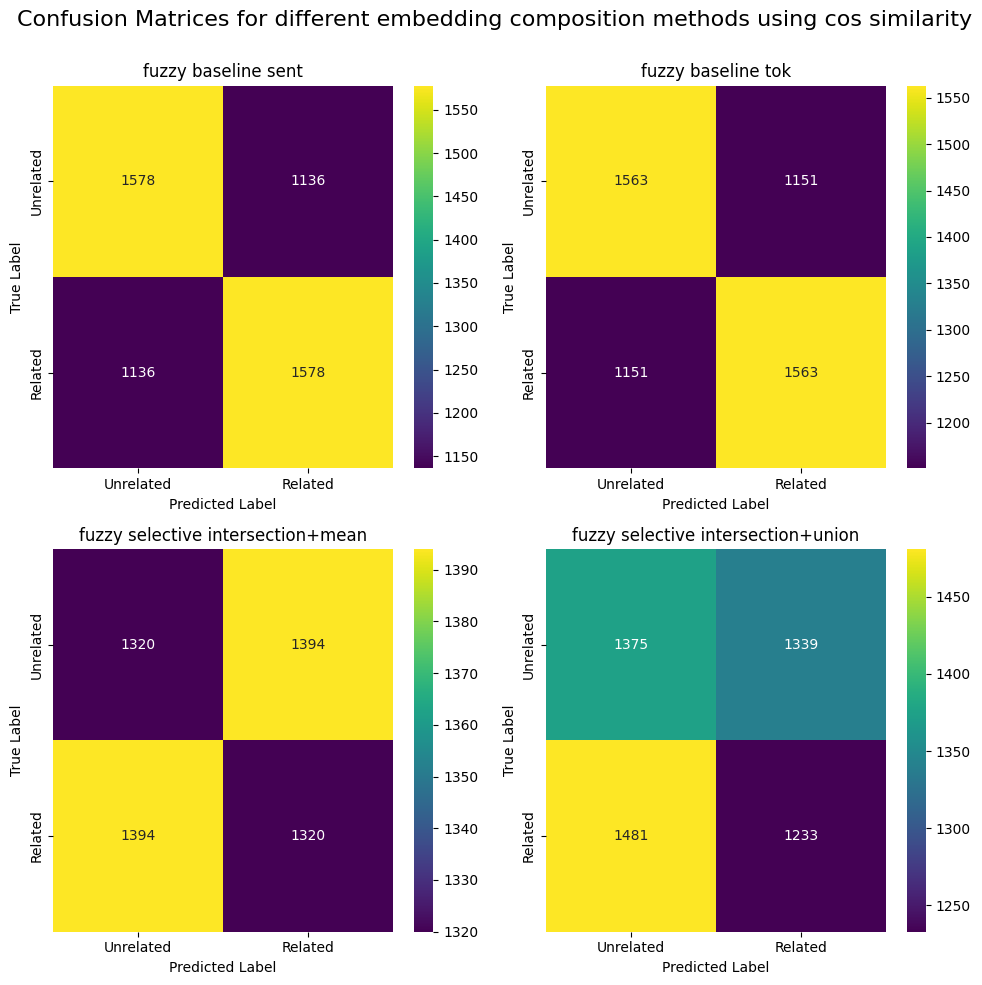

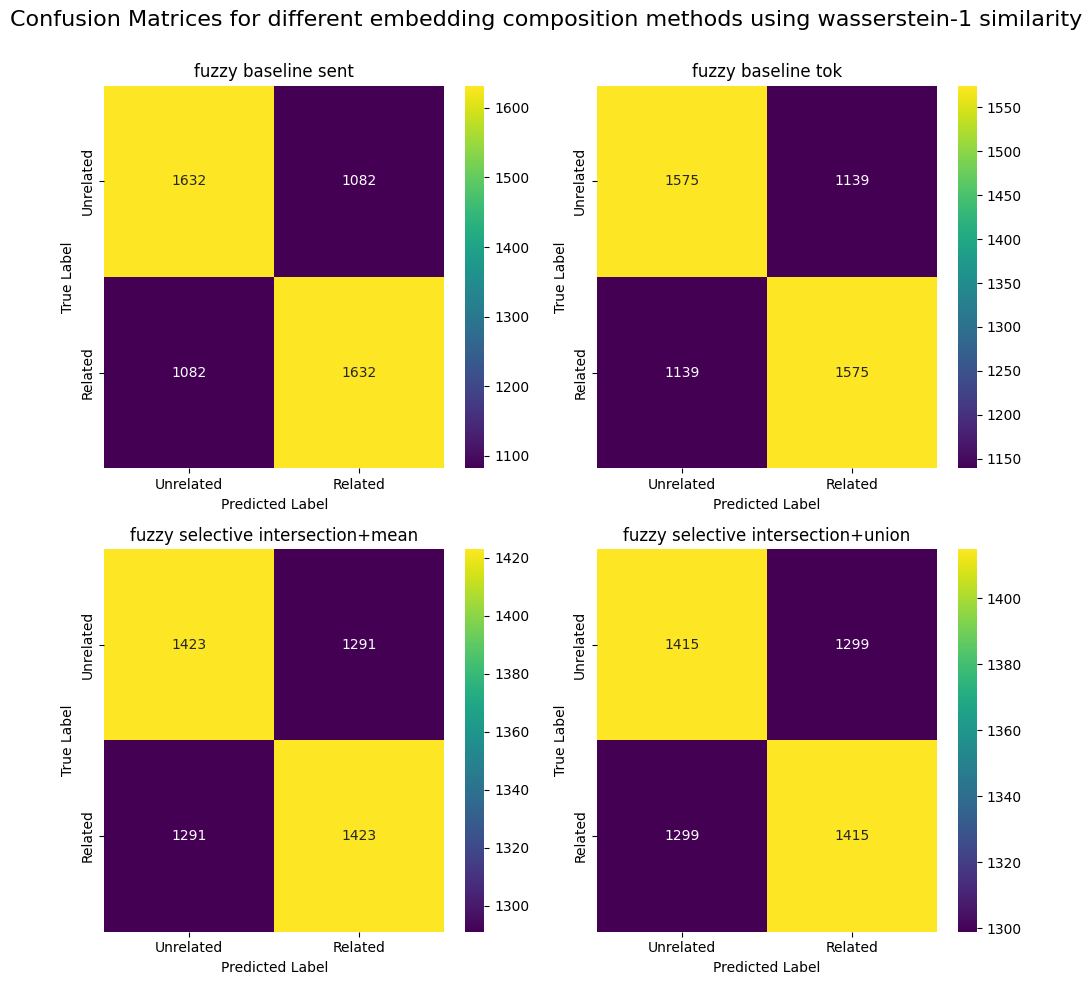

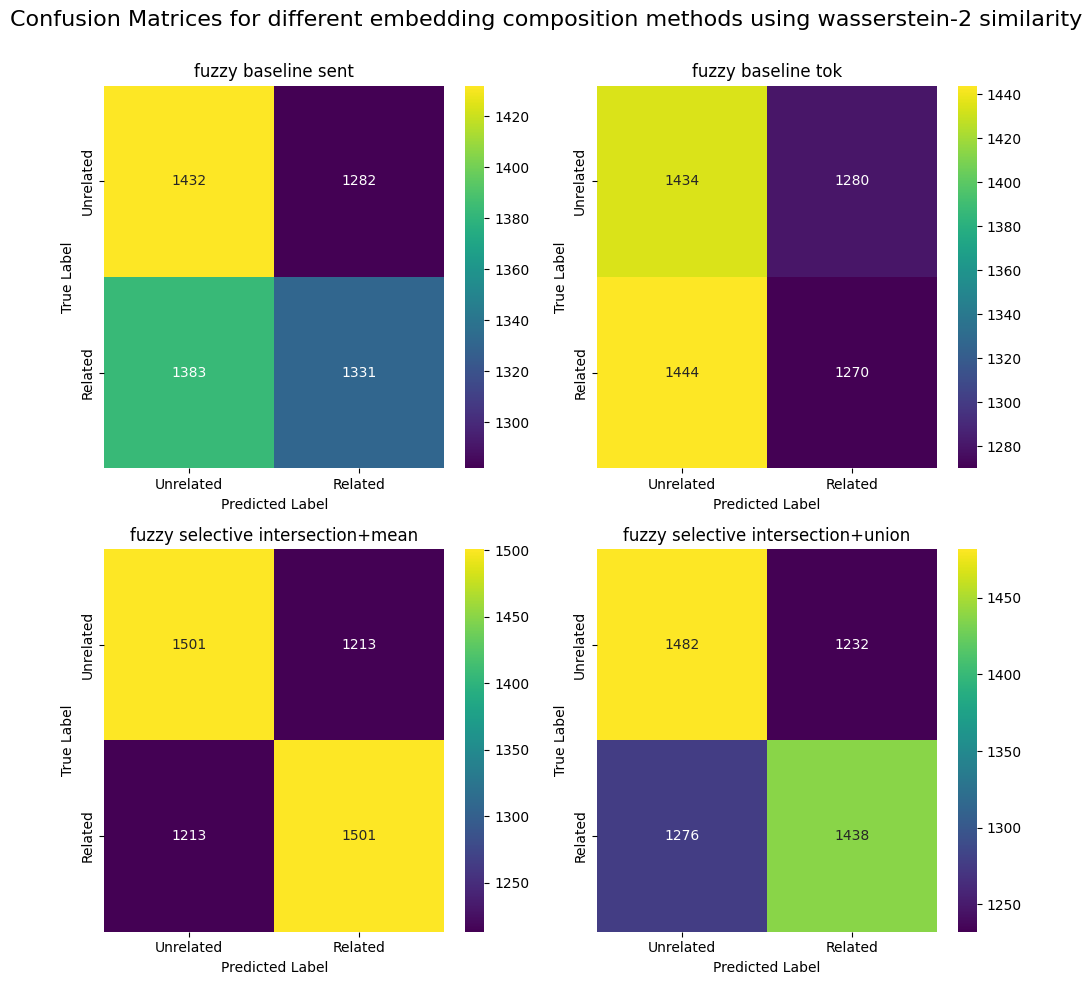

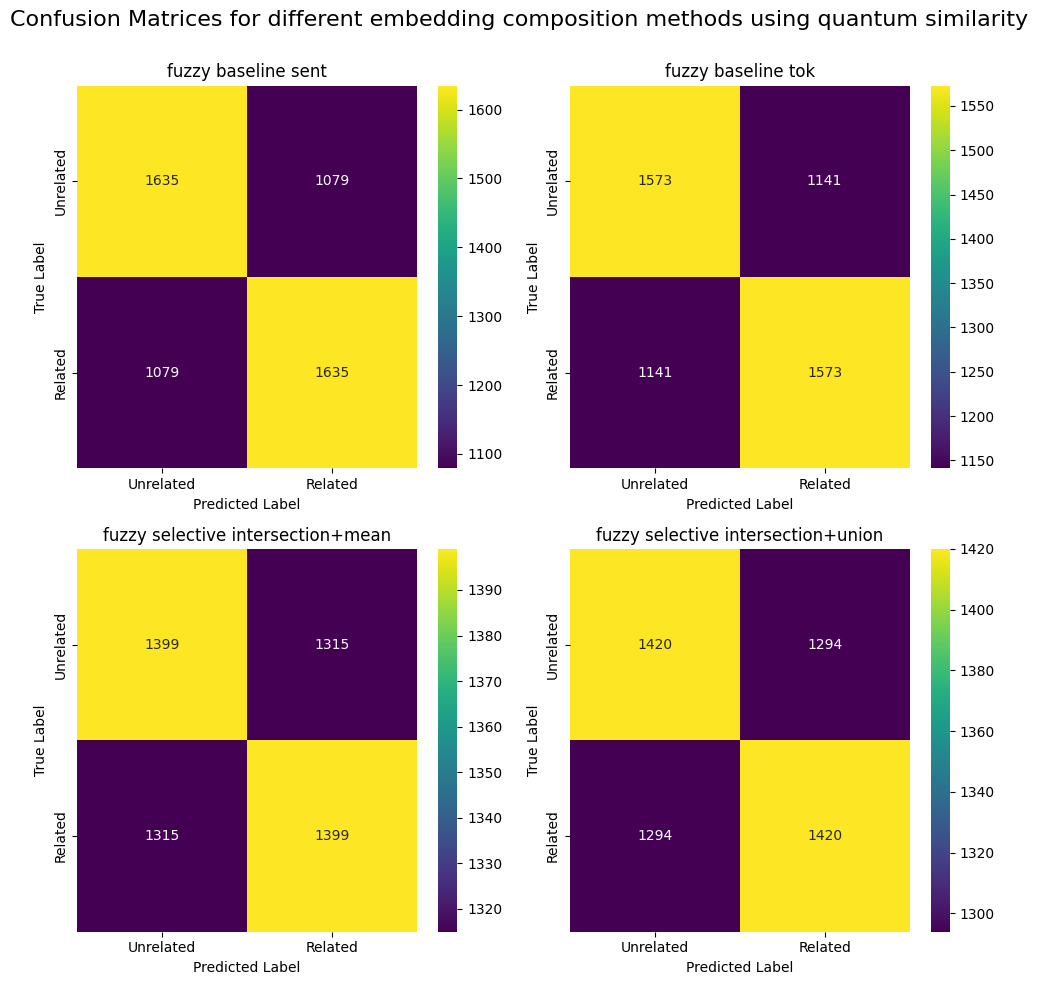

In [12]:
models = [
    "baseline_sent",
    "baseline_tok",
    "selective_intersection+mean",
    "selective_intersection+union",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"fuzzy_{model}_{sim_metric}_sim_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_train
)

# Evaluation Results

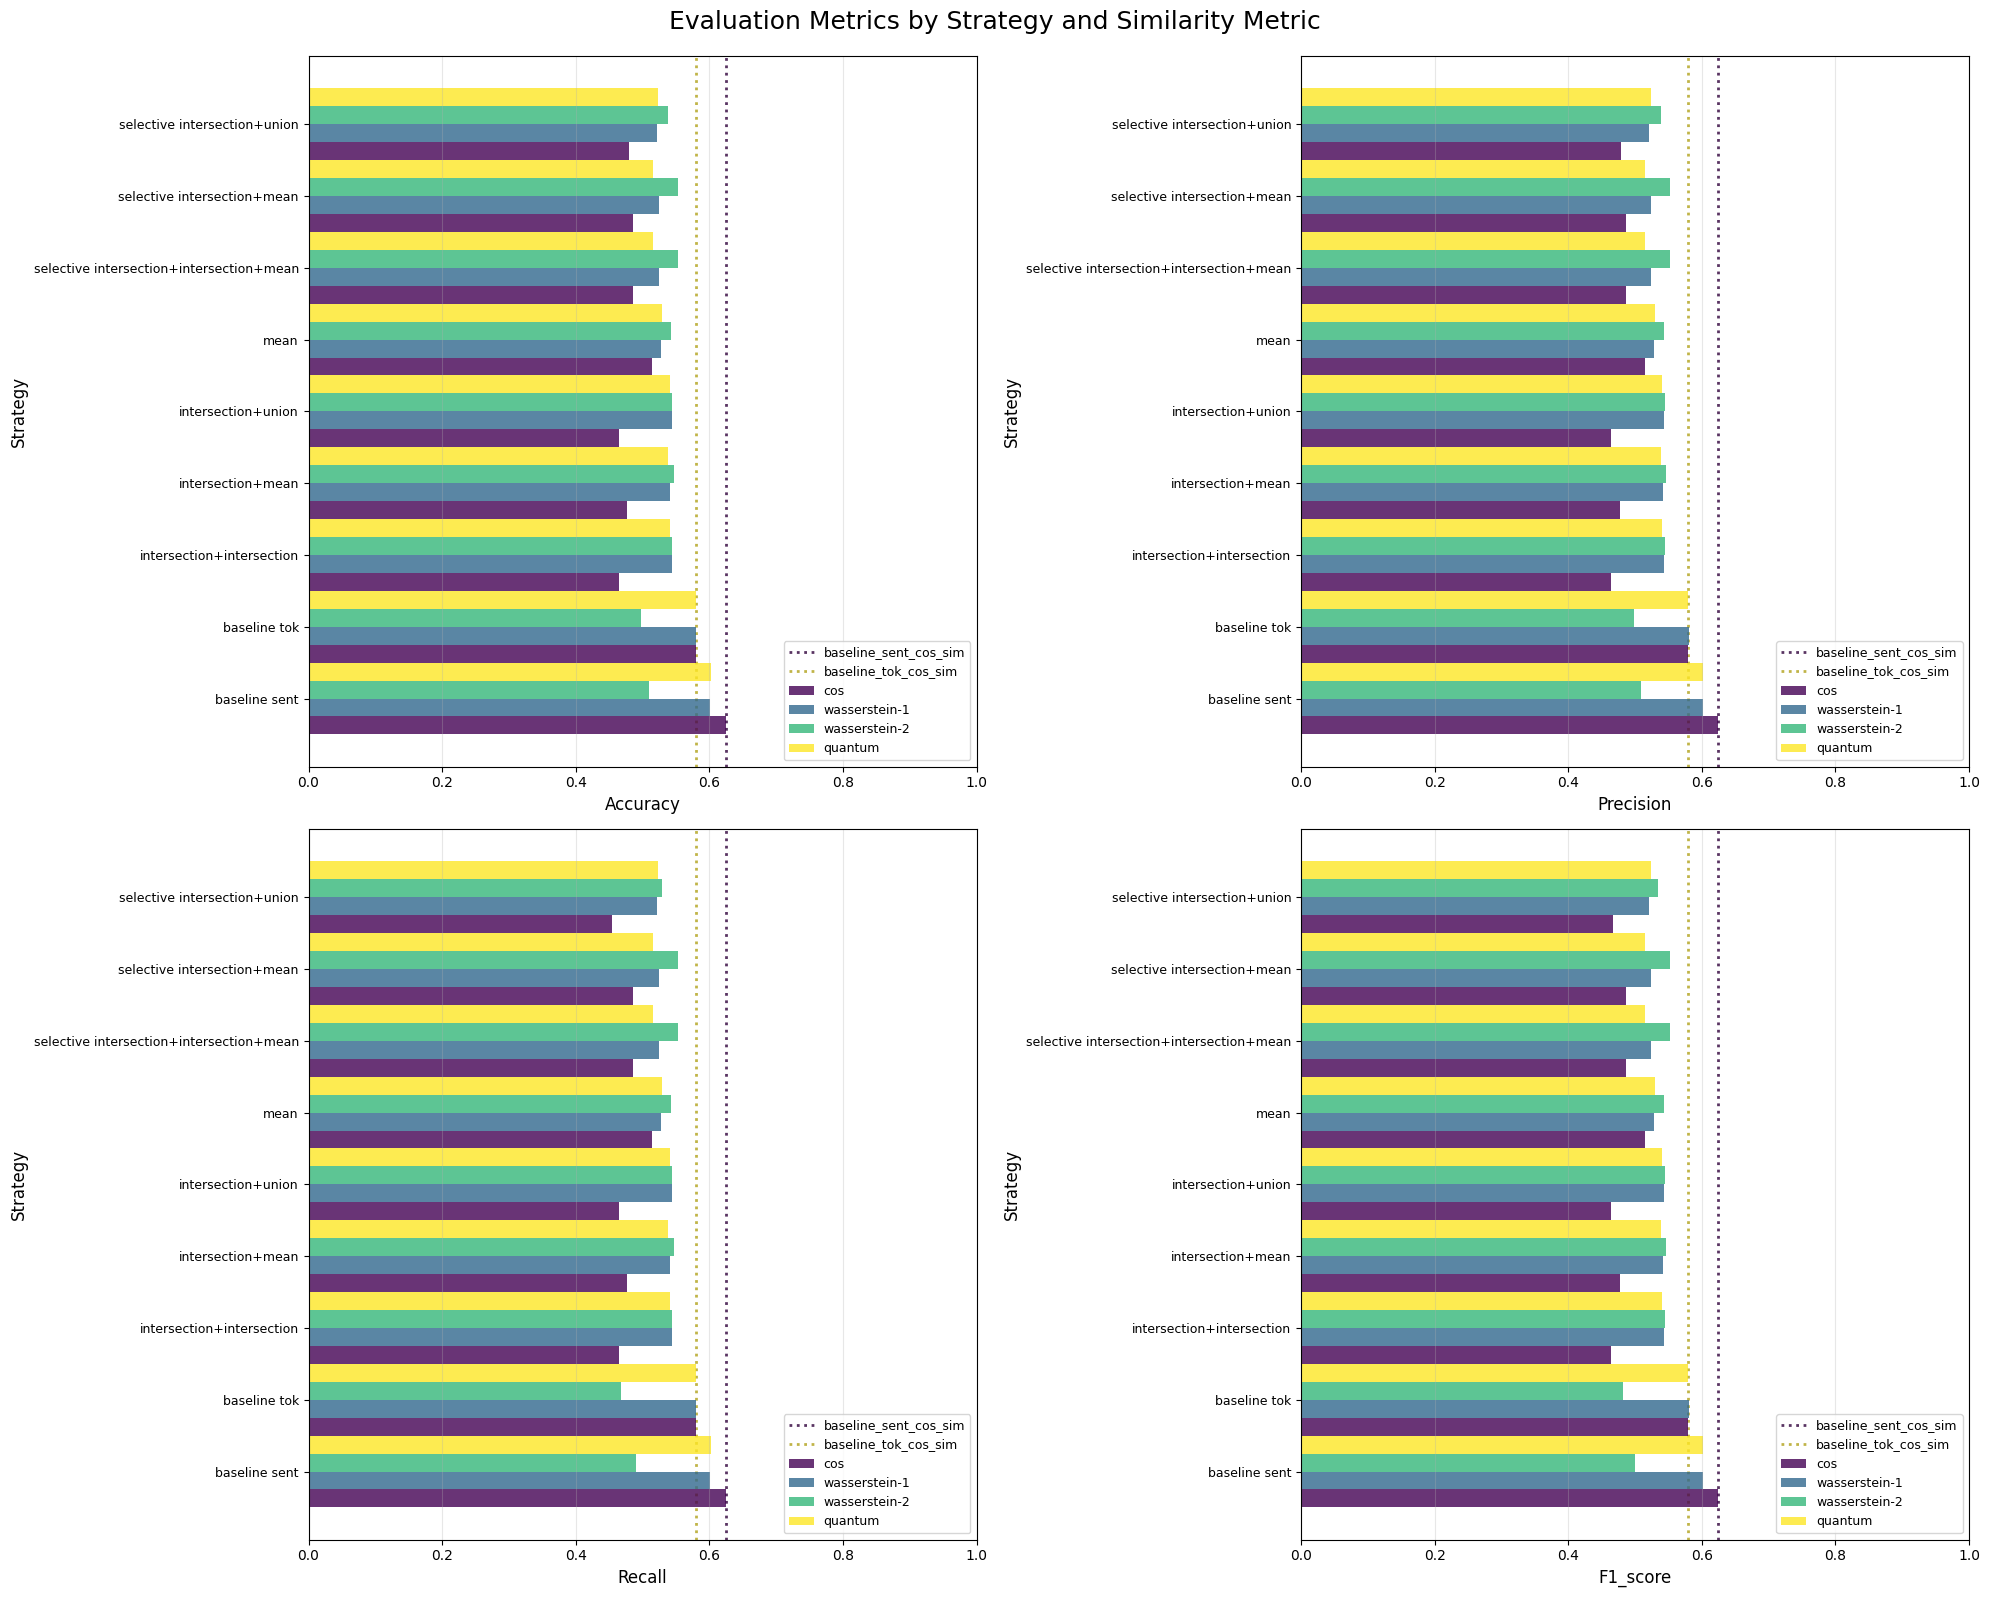

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,baseline_sent,cos,baseline_sent_cos_sim,0.624539,0.624539,0.624539,0.624539
1,baseline_sent,quantum,fuzzy_baseline_sent_quantum_sim,0.602432,0.602432,0.602432,0.602432
2,baseline_sent,wasserstein-1,fuzzy_baseline_sent_wasserstein-1_sim,0.601326,0.601326,0.601326,0.601326
3,baseline_sent,cos,fuzzy_baseline_sent_cos_sim,0.581430,0.581430,0.581430,0.581430
4,baseline_tok,wasserstein-1,fuzzy_baseline_tok_wasserstein-1_sim,0.580324,0.580324,0.580324,0.580324
5,baseline_tok,cos,baseline_tok_cos_sim,0.579956,0.579956,0.579956,0.579956
6,baseline_tok,quantum,fuzzy_baseline_tok_quantum_sim,0.579587,0.579587,0.579587,0.579587
7,baseline_tok,cos,fuzzy_baseline_tok_cos_sim,0.575903,0.575903,0.575903,0.575903
8,selective_intersection+intersection+mean,wasserstein-2,fuzzy_selective_intersection+intersection+mean...,0.553058,0.553058,0.553058,0.553058
9,selective_intersection+mean,wasserstein-2,fuzzy_selective_intersection+mean_wasserstein-...,0.553058,0.553058,0.553058,0.553058


In [10]:
metrics_df = eval_harness.score(sim_eval_df, y_train)
metrics_df[:10]

In [11]:
metrics_df.to_csv(f"full_train_eval-wn_enriched={enrich_lemmas_with_wn}-n_components={n_components}-kernel_size={fuzzification_kernel_size}.tsv", sep="\t")